I tried and failed to convert a `PySpark DataFrame` that I was working in to one in `pandas` for the better part of an hour tonight.

Ultimately figured out a naive workaround and wanted to leave a solution behind for anybody googling the error message

```
TypeError: Cannot convert tz-naive Timestamp, use tz_localize to localize
```

[This poor soul](https://stackoverflow.com/questions/49349824/date-conversion-error-while-loading-into-pandas-dataframe-from-spark-dataframe) was running into the same issue a few months ago, and it's, hilariously, the only hit you get when looking up this issue on the whole, wide Internet.

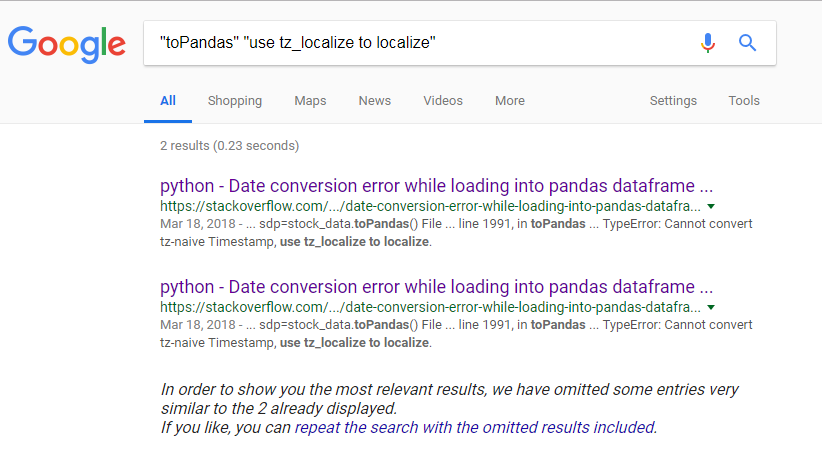

In [1]:
from IPython.display import Image
Image('../images/errormsg.PNG')

## Follow the Docs

In [2]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext()

spark = pyspark.sql.SparkSession(sc)

If you look at the [PySpark documentation around this function](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.toPandas), they have a super-vanilla example that takes a simple table that looks like this

In [3]:
from pyspark.sql import Row

data = [Row(name='Alice', age=2),
        Row(name='Bob', age=5)]

pysparkDf = spark.createDataFrame(data)

In [4]:
pysparkDf.show()

+---+-----+
|age| name|
+---+-----+
|  2|Alice|
|  5|  Bob|
+---+-----+



and pipes it, all nice and neat, into a `pandas.DataFrame` so we can do some rich data analysis. For my money, this is probably the best real-world example I've seen in any documentation.

In [5]:
df = pysparkDf.toPandas()
df

,age,name
0,2,Alice
1,5,Bob


## Recreate the Problem

Imagine, however, that your data looks like something closer to a server log, and there's a third field, `sessionDt` that gets captured as well.

In [6]:
from datetime import datetime

data = [Row(name='Alice', age=2, sessionDt=datetime.now()),
        Row(name='Bob', age=5, sessionDt=datetime.now())]

pysparkDf = spark.createDataFrame(data)

Now we've got 3 columns

In [7]:
pysparkDf.show()

+---+-----+--------------------+
|age| name|           sessionDt|
+---+-----+--------------------+
|  2|Alice|2018-06-06 21:20:...|
|  5|  Bob|2018-06-06 21:20:...|
+---+-----+--------------------+



One of which is of type `timestamp`

In [8]:
pysparkDf.dtypes

[('age', 'bigint'), ('name', 'string'), ('sessionDt', 'timestamp')]

And `pandas` loses its damn mind.

In [9]:
pysparkDf.toPandas()

TypeError: Cannot convert tz-naive Timestamp, use tz_localize to localize

### Timestamp?

And so you ensure that your `SparkSession` exists in *some* localized timestamp

In [10]:
spark.conf.get('spark.sql.session.timeZone')

'America/New_York'

Ah. Maybe my computer's just confused about where it's at.

In [11]:
spark.conf.set('spark.sql.session.timeZone', 'America/Detroit')

In [12]:
spark.conf.get('spark.sql.session.timeZone')

'America/Detroit'

And you run it again

In [13]:
data = [Row(name='Alice', age=2, sessionDt=datetime.now()),
        Row(name='Bob', age=5, sessionDt=datetime.now())]

try:
    pysparkDf = spark.createDataFrame(data)
    pysparkDf.toPandas()
except:
    print('Lol, nope')

Lol, nope


### Save me, Unix

And so you think to yourself, "well maybe if I convert it to unix..."

In [14]:
from pyspark.sql import functions as F

unix = pysparkDf.withColumn('sessionDt', F.unix_timestamp('sessionDt'))
unix.collect()

[Row(age=2, name='Alice', sessionDt=1528334487),
 Row(age=5, name='Bob', sessionDt=1528334487)]

"...And then try and convert it *back* to a `timestamp`..."

In [15]:
notUnix = unix.withColumn('sessionDt', F.from_unixtime(unix['sessionDt']))
notUnix.collect()

[Row(age=2, name='Alice', sessionDt='2018-06-06 21:21:27'),
 Row(age=5, name='Bob', sessionDt='2018-06-06 21:21:27')]

"...maybe it will just work for some reason?"

In [16]:
notUnix.toPandas()

,age,name,sessionDt
0,2,Alice,2018-06-06 21:21:27
1,5,Bob,2018-06-06 21:21:27


I'm going to throw up. That worked?

In [17]:
noWay = notUnix.toPandas()
noWay.head()

,age,name,sessionDt
0,2,Alice,2018-06-06 21:21:27
1,5,Bob,2018-06-06 21:21:27


**How in the hell did that work??**

Oh...

In [18]:
noWay.dtypes

age           int64
name         object
sessionDt    object
dtype: object

Because `sessionDt` read in as a string.

## Actually...

That's not the *stupidest* idea I've ever had.

In [19]:
import pandas as pd

df = pysparkDf.withColumn('sessionDt',
                          pysparkDf['sessionDt'].cast('string')).toPandas()

df['sessionDt'] = pd.to_datetime(df['sessionDt'])
df

,age,name,sessionDt
0,2,Alice,2018-06-06 21:21:27.981390
1,5,Bob,2018-06-06 21:21:27.981390


In [20]:
df.dtypes

age                   int64
name                 object
sessionDt    datetime64[ns]
dtype: object